<h1>Анализ формулы один с использованием методов машинного обучения и математической статистики</h1>

<h2>Первоначальной нашей целью будет прогноз вероятности совершения обгона на каждом из участков трассы.</h2>

In [2]:
import fastf1 as ff1
import pandas as pd
import numpy as np
import datetime
import math

ff1.Cache.enable_cache('cache')
session = ff1.get_session(2021, 22, 'R')
quali = ff1.get_session(2021, 22, 'Q')
quali = pd.DataFrame(quali.results)

In [3]:
laps = session.load_laps(with_telemetry=True)
session.load_telemetry()

core           INFO 	Loading laps for Abu Dhabi Grand Prix - Race [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
utils          INFO 	NumExpr defaulting to 8 threads.
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 19 drivers: ['5', '7', '18', '3', '99', '77', '16', '47', '33', '10', '4', '14', '11', '6', '44', '31', '63', '22', '55']
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data


In [24]:
laps

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,SpeedST,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 01:03:54.885000,33,NaT,1,1,0 days 00:23:01.492000,NaT,NaT,0 days 00:00:38.428000,0 days 00:00:33.563000,...,318.0,SOFT,4.0,False,0 days 01:02:21.871000,Red Bull,VER,1,False,2021-12-12 13:03:21.881
1,0 days 01:05:23.988000,33,0 days 00:01:29.103000,2,1,NaT,NaT,0 days 00:00:18.116000,0 days 00:00:38.026000,0 days 00:00:32.961000,...,302.0,SOFT,5.0,False,0 days 01:03:54.885000,Red Bull,VER,1,True,2021-12-12 13:04:54.895
2,0 days 01:06:52.815000,33,0 days 00:01:28.827000,3,1,NaT,NaT,0 days 00:00:17.999000,0 days 00:00:38.043000,0 days 00:00:32.785000,...,301.0,SOFT,6.0,False,0 days 01:05:23.988000,Red Bull,VER,1,True,2021-12-12 13:06:23.998
3,0 days 01:08:21.841000,33,0 days 00:01:29.026000,4,1,NaT,NaT,0 days 00:00:18.019000,0 days 00:00:38.125000,0 days 00:00:32.882000,...,303.0,SOFT,7.0,False,0 days 01:06:52.815000,Red Bull,VER,1,True,2021-12-12 13:07:52.825
4,0 days 01:09:50.559000,33,0 days 00:01:28.718000,5,1,NaT,NaT,0 days 00:00:17.999000,0 days 00:00:38.083000,0 days 00:00:32.636000,...,303.0,SOFT,8.0,False,0 days 01:08:21.841000,Red Bull,VER,1,True,2021-12-12 13:09:21.851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0 days 02:24:55.281000,47,0 days 00:02:11.605000,53,3,0 days 02:23:04.752000,NaT,0 days 00:00:40.395000,0 days 00:00:48.541000,0 days 00:00:42.669000,...,203.0,SOFT,4.0,False,0 days 02:22:43.676000,Haas F1 Team,MSC,4,False,2021-12-12 14:23:43.686
994,0 days 02:26:39.361000,47,0 days 00:01:44.080000,54,3,NaT,NaT,0 days 00:00:19.591000,0 days 00:00:42.890000,0 days 00:00:41.599000,...,268.0,SOFT,5.0,False,0 days 02:24:55.281000,Haas F1 Team,MSC,4,False,2021-12-12 14:25:55.291
995,0 days 02:28:57.976000,47,0 days 00:02:18.615000,55,3,NaT,NaT,0 days 00:00:22.400000,0 days 00:01:02.169000,0 days 00:00:54.046000,...,257.0,SOFT,6.0,False,0 days 02:26:39.361000,Haas F1 Team,MSC,4,False,2021-12-12 14:27:39.371
996,0 days 02:31:17.001000,47,0 days 00:02:19.025000,56,3,NaT,NaT,0 days 00:00:28.870000,0 days 00:00:56.316000,0 days 00:00:53.839000,...,258.0,SOFT,7.0,False,0 days 02:28:57.976000,Haas F1 Team,MSC,4,False,2021-12-12 14:29:57.986


In [29]:
laps['LapEndTime'] = laps['LapStartTime'] + laps['LapTime']

Сделаем подготовку данных для просчета обгонов
Отберем для каждого гонщика те записи, где менялся гонщик впереди, аналогичные же записи отберем для других гонщиков

In [28]:
def get_ticks_to_process(laps_to_process):
    driver_numbers =  laps_to_process['DriverNumber'].unique()
    ticks_to_process = []
    for driver in driver_numbers:
        telemetry = laps_to_process.pick_driver(driver).get_telemetry()
        data = telemetry['DriverAhead'].to_frame()
        data['DriverAhead'] = pd.to_numeric(data['DriverAhead'])
        data = data.fillna(0)
        data = data.diff(axis=0)
        telemetry['DriverAhead_difference'] = data['DriverAhead']
        telemetry.dropna(subset = ['DriverAhead_difference'], inplace=True)
        telemetry = telemetry[(telemetry['DriverAhead_difference'] != 0)]
        ticks_to_process += list(telemetry['Time'].unique())
    return list(sorted(list(dict.fromkeys(ticks_to_process))))

In [78]:
# взять текущий тик -> ближайший тик гонщика впереди -> ближайший тик его гонщика и т.д. ...
def sort_not_calculated(drivers_to_process, laps_to_process, last_driver_in_peleton, current_time):
    drivers_dict = {}
    drivers_to_delete = []
    result = []

    for driver in drivers_to_process:
        driver_ahead = laps_to_process.pick_driver(driver).get_telemetry()
        ahead_tick = driver_ahead[(driver_ahead['Time'] >= current_time)].index.min()
        ahead_tick = driver_ahead.loc[ahead_tick]
        if len(ahead_tick) == 0:
            drivers_to_delete.append(driver)
            break
        driver_ahead_num = ahead_tick['DriverAhead']
        try:
            _ = drivers_dict[driver_ahead_num]
            return [], drivers_to_delete, True
        except Exception as _:
            drivers_dict[driver_ahead_num] = driver

    for c in range(len(drivers_dict)):
        try:
            last_driver_in_peleton = drivers_dict[last_driver_in_peleton]
            result.append(last_driver_in_peleton)
        except Exception as _:
            return [], drivers_to_delete, True

    return result, drivers_to_delete, False


def get_peleton_by_tick(current_time, driver_laps_to_process, drivers_peleton_to_process, laps_to_process):
    current_time_index = driver_laps_to_process[driver_laps_to_process['Time'] > current_time].index.min()
    tick = driver_laps_to_process.loc[[current_time_index]].iloc[0]
    current_time = tick['Time']
    print(current_time)
    driver_ahead_num = tick['DriverAhead']
    current_peleton = [int(drivers_peleton_to_process[0]), int(tick['DriverAhead'])]
    error_counter = 0
    max_possible_num_of_errors = 0
    while driver_ahead_num != '':
        driver_ahead = laps.pick_driver(driver_ahead_num).get_telemetry()
        ahead_tick = driver_ahead[(driver_ahead['Time'] >= current_time)].index.min()
        ahead_tick = driver_ahead.loc[ahead_tick]
        driver_ahead_num = ahead_tick['DriverAhead']

        if error_counter > max_possible_num_of_errors:
            not_calculated_drivers = list(set(drivers_peleton_to_process).difference(current_peleton))
            print(not_calculated_drivers, driver_ahead_num, current_peleton, 'too much errors')
            return current_peleton, not_calculated_drivers, True, current_time # последний параметр отвечает за успешность обработки tick'а

        if driver_ahead_num != '':
            driver_ahead_num = int(driver_ahead_num)
            if driver_ahead_num not in current_peleton:
                current_peleton.append(driver_ahead_num)
            elif driver_ahead_num == current_peleton[-2]:
                current_peleton = current_peleton[:-2] + [current_peleton[-1], current_peleton[-2]]
                driver_ahead = laps_to_process.pick_driver(driver_ahead_num).get_telemetry()
                current_time_index = driver_ahead[(driver_ahead['Time'] > current_time) & (driver_ahead['DriverAhead'] != '')].index.min()
                current_time = driver_ahead.loc[[current_time_index]].iloc[0]['Time']
            else:
                driver_ahead_num = current_peleton[0]
                current_peleton = current_peleton[:1]
                current_time_index = driver_laps_to_process[driver_laps_to_process['Time'] > current_time].index.min()
                tick = driver_laps_to_process.loc[[current_time_index + 1]].iloc[0]
                current_time = tick['Time']
                max_possible_num_of_errors = 2
                error_counter += 1
                print('tick updated')
        else:
            not_calculated_drivers = list(set(drivers_peleton_to_process).difference(current_peleton))
            updated_tail, drivers_to_delete, error = sort_not_calculated(not_calculated_drivers, laps_to_process, current_peleton[0], current_time)
            current_peleton = updated_tail + current_peleton
            for driver in drivers_to_delete:
                drivers_peleton_to_process.remove(driver)
            if error:
                driver_ahead_num = not_calculated_drivers[0]
                current_peleton = not_calculated_drivers[:1]
                current_time_index = driver_laps_to_process[driver_laps_to_process['Time'] > current_time].index.min()
                tick = driver_laps_to_process.loc[[current_time_index + 1]].iloc[0]
                current_time = tick['Time']
                max_possible_num_of_errors = max(2, len(not_calculated_drivers))
                error_counter += 1
                print('tick updated from tail')
            else:
                return current_peleton, not_calculated_drivers, False, current_time # последний параметр отвечает за успешность обработки tick'а

In [48]:
drivers_peleton_all = list(map(int, reversed(quali['number'].tolist())))
drivers_peleton = []
for i in range(len(drivers_peleton_all)):
    try:
        _ = laps.pick_driver(drivers_peleton_all[i]).get_telemetry()
        drivers_peleton.append(drivers_peleton_all[i])
    except Exception as _:
        pass

overtakes_to_process = get_ticks_to_process(laps)

In [ ]:
print(datetime.datetime.now())
success_ticks = 0
failed_ticks = 0
peleton = drivers_peleton[:1]
last_time = 0
drivers_peleton_updates = {'Peleton': [], 'Not_proceeded': [], 'Time_min': [], 'Time_max': []}
for overtake_tick in overtakes_to_process:
    if overtake_tick > last_time:
        driver_laps = laps.pick_driver(peleton[0]).get_telemetry()
        peleton, not_processed, failed, last_time = get_peleton_by_tick(overtake_tick, driver_laps, drivers_peleton, laps)
        if not failed:
            success_ticks += 1
            drivers_peleton_updates['Peleton'].append(peleton)
            drivers_peleton_updates['Not_proceeded'].append(not_processed)
            drivers_peleton_updates['Time_min'].append([overtake_tick])
            drivers_peleton_updates['Time_max'].append([overtake_tick])
            print('success', peleton, not_processed)
        else:
            failed_ticks += 1
            print('failed', peleton, not_processed)
print(success_ticks / (success_ticks + failed_ticks))

2022-03-10 01:40:31.315311
0 days 00:00:00.681000
tick updated
tick updated from tail
success [5, 47, 18, 33, 22, 14, 10, 11, 55, 63, 99, 3, 4, 77, 31, 7, 16, 6, 44] []
0 days 00:00:02.661000
tick updated from tail
tick updated from tail
success [47, 5, 33, 18, 10, 22, 14, 63, 11, 55, 99, 31, 4, 77, 3, 16, 6, 7, 44] []
0 days 00:00:03.321000
success [47, 5, 33, 10, 18, 14, 22, 63, 11, 55, 31, 99, 4, 77, 16, 3, 7, 6, 44] []
0 days 00:00:03.541000
success [47, 5, 33, 18, 10, 14, 22, 11, 63, 55, 31, 4, 99, 77, 3, 16, 7, 6, 44] []
0 days 00:00:03.761000
success [47, 5, 33, 14, 18, 10, 22, 11, 63, 55, 31, 4, 99, 77, 16, 3, 6, 7, 44] []
0 days 00:00:03.981000
success [47, 5, 33, 14, 10, 18, 22, 11, 31, 63, 55, 4, 99, 77, 16, 3, 6, 7, 44] []
0 days 00:00:04.201000
success [47, 5, 33, 14, 18, 10, 22, 11, 31, 63, 55, 4, 99, 77, 16, 3, 6, 7, 44] []
0 days 00:00:04.421000
success [47, 33, 5, 14, 18, 10, 22, 11, 31, 63, 55, 99, 4, 77, 16, 3, 7, 6, 44] []
0 days 00:00:04.861000
success [47, 33, 5, 

In [ ]:
drivers_peleton_updates_df = pd.DataFrame(drivers_peleton_updates)
drivers_peleton_updates_df.to_csv('overtakes.csv', encoding='utf-8', index=False)

<h3> Дальнейшая работа и алгоритм вычисления места обгона </h3>
Алгоритм следующий: для каждого гонщика считается его текущая позиция в каждый момент предполагаемого обгона. Обгон засчитывается, если позиция не была возвращена до конца круга, аналогично в дальнейших версиях алгоритма стоит исключить обгоны из-за заездов на питстоп. Таким образом, алгоритм будет следующим:
<ol style="color: green">
<li>Посчитать сетку на конец круга</li>
<li>Найти смены позиций, если таковые были</li>
<li>Найти где была произведена окончательная смена позиций</li>
<li style="color: red">Выделить места борьбы за место</li>
</ol>

In [154]:
def get_starting_grid(laps_data, quali_data):
    quali_grid = quali_data['number'].tolist()
    race_starting = []
    for driver in range(len(quali_grid)):
        try:
            _ = laps_data.pick_driver(quali_grid[driver]).get_telemetry()
            race_starting.append(quali_grid[driver])
        except Exception as _:
            pass
    return np.array(race_starting)

def calculate_lap_grid(data, lap_num):
    return data[data['LapNumber'] == lap_num].sort_values(by=['LapEndTime'])

def get_position_of_overtake(data, overtaken_driver, driver):
    driver_data = data.pick_driver(overtaken_driver).get_telemetry()
    index = driver_data[driver_data['DriverAhead'] == driver].index.min()
    return [None, None] if np.isnan(index) else [driver_data.loc[[index]].iloc[0]['X'], driver_data.loc[[index]].iloc[0]['Y']]

def find_and_process_overtake(grid_to_process, data, lap_number):
    overtaken_driver = grid_to_process[-1]
    lap_data = data[data['LapNumber'] == lap_number]
    overtakes = []
    for driver in grid_to_process[:-1]:
        x, y = get_position_of_overtake(lap_data, overtaken_driver, driver)
        if x is not None:
            overtakes.append([x, y])
    return overtakes

def calculate_overtakes(grid_to_process, difference_in_grid, data, lap_number):
    overtakes_to_find = []
    i = 0
    while i < len(difference_in_grid):
        if difference_in_grid[i] < 0:
            overtakes_to_find += (find_and_process_overtake(grid_to_process[i + difference_in_grid[i]:i + 1], data, lap_number))
            difference_in_grid[i + difference_in_grid[i]:i] += np.full(len(difference_in_grid[i + difference_in_grid[i]:i]), -1)
            difference_in_grid[i] = 0
            difference_in_grid = np.array(list(difference_in_grid[:i + difference_in_grid[i]]) + list(difference_in_grid[i + difference_in_grid[i]:i]) + list(difference_in_grid[i:]))
            i += difference_in_grid[i] - 1
            # difference_in_grid = np.concatenate([difference_in_grid[:i + difference_in_grid[i]], difference_in_grid[i + difference_in_grid[i]:i], difference_in_grid[i:]])
        i += 1
    return overtakes_to_find

In [155]:
previous_grid = np.array(get_starting_grid(laps, quali))
overtakes = []
for i in range(1, laps['LapNumber'].max() + 1):
    transition_grid = dict(zip(previous_grid, np.arange(1, len(previous_grid) + 1)))
    previous_grid = np.arange(1, len(previous_grid) + 1)
    current_grid = calculate_lap_grid(laps, i)['DriverNumber'].to_list()
    previous_grid = current_grid
    current_grid = np.array([transition_grid[driver] for driver in current_grid])
    difference = current_grid - np.array(sorted(current_grid))
    overtakes += calculate_overtakes(previous_grid, difference, laps, i)

[[872, 2115],
 [736, 2100],
 [745, 2102],
 [756, 2103],
 [2003, -3808],
 [2439, -1362],
 [851, 2114],
 [-1885, 614],
 [106, 1870],
 [802, 1957],
 [3521, 2295],
 [1508, 2045],
 [1590, -3467],
 [-195, 1836],
 [-129, 2028],
 [2017, 2108],
 [2293, 2143],
 [2429, 2159],
 [2449, 2163],
 [2450, 2162],
 [2491, 2168],
 [3076, 2240],
 [4270, 2965],
 [930, 1973],
 [1675, 2066],
 [2029, 2110],
 [2208, 2132],
 [2209, 2133],
 [3149, 2249],
 [1411, 2033],
 [3845, 2330],
 [-240, 1831],
 [-587, 5527],
 [-2174, 851],
 [312, 1896],
 [684, 1943],
 [1151, 2001],
 [2292, 2142],
 [2557, 2175],
 [1993, 2106],
 [3535, 2297],
 [4510, 2455],
 [4204, 3253],
 [1492, 2043],
 [2887, 2216],
 [2920, 2220],
 [2948, 2224],
 [2921, 2220],
 [1291, 2018],
 [1719, 2071],
 [1734, 2073],
 [1735, 2074],
 [2220, 2134],
 [3322, 2271],
 [3977, 2347],
 [4445, 2751],
 [2209, 2132],
 [2413, 2158],
 [4482, 2430],
 [4488, 2707],
 [4691, -5214],
 [-2153, 661],
 [564, -2602],
 [88, 7395],
 [4583, -5172],
 [-218, 1834],
 [4661, -5202],
 

In [164]:
overtakes

[[872, 2115],
 [736, 2100],
 [745, 2102],
 [756, 2103],
 [2003, -3808],
 [2439, -1362],
 [851, 2114],
 [-1885, 614],
 [106, 1870],
 [802, 1957],
 [3521, 2295],
 [1508, 2045],
 [1590, -3467],
 [-195, 1836],
 [-129, 2028],
 [2017, 2108],
 [2293, 2143],
 [2429, 2159],
 [2449, 2163],
 [2450, 2162],
 [2491, 2168],
 [3076, 2240],
 [4270, 2965],
 [930, 1973],
 [1675, 2066],
 [2029, 2110],
 [2208, 2132],
 [2209, 2133],
 [3149, 2249],
 [1411, 2033],
 [3845, 2330],
 [-240, 1831],
 [-587, 5527],
 [-2174, 851],
 [312, 1896],
 [684, 1943],
 [1151, 2001],
 [2292, 2142],
 [2557, 2175],
 [1993, 2106],
 [3535, 2297],
 [4510, 2455],
 [4204, 3253],
 [1492, 2043],
 [2887, 2216],
 [2920, 2220],
 [2948, 2224],
 [2921, 2220],
 [1291, 2018],
 [1719, 2071],
 [1734, 2073],
 [1735, 2074],
 [2220, 2134],
 [3322, 2271],
 [3977, 2347],
 [4445, 2751],
 [2209, 2132],
 [2413, 2158],
 [4482, 2430],
 [4488, 2707],
 [4691, -5214],
 [-2153, 661],
 [564, -2602],
 [88, 7395],
 [4583, -5172],
 [-218, 1834],
 [4661, -5202],
 

## Посмотрим на визуализацию мест обгонов на одной конкретной трассе за разные года. Для этого выберем трассу которая не менялась с 2014 года.
 <i style="color: #ff2800"> небольшое уточнение, все координаты представлены в 1/10 метра, мы разделим всю трассу на зоны

In [158]:
x_size_of_sector = 50
y_size_of_sector = 50

<h2> Давайте создадим нашу трассу </h2>

In [161]:
def num_of_overtakes_in_segment(point, overtakes_df):
    return len(overtakes_df[(overtakes_df['X'] == math.floor(point['X'] // 10  // x_size_of_sector)) & (overtakes_df['Y'] == math.floor(point['Y'] // 10 // y_size_of_sector))])

lap = laps.pick_fastest()
tel = lap.get_telemetry()

x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

overtakes_to_display = pd.DataFrame({"X": [x[0] for x in overtakes], "Y": [x[1] for x in overtakes]})
overtakes_to_display.apply(lambda i: math.floor(i['X'] // 10  // x_size_of_sector), axis=1)
overtakes_to_display.apply(lambda i: math.floor(i['Y'] // 10  // x_size_of_sector), axis=1)
# overtakes_to_display['X'] = math.floor(overtakes_to_display['X'] // 10  // x_size_of_sector)
# overtakes_to_display['Y'] = math.floor(overtakes_to_display['Y'] // 10  // x_size_of_sector)
overtakes_to_display['nOvertakes'] = overtakes_to_display.apply(lambda i: num_of_overtakes_in_segment(i, overtakes_to_display), axis=1)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

In [162]:
overtakes_to_display.sort_values(by='nOvertakes', ascending=False)

,X,Y,nOvertakes
0,872,2115,0
108,-1958,1758,0
101,701,2097,0
102,725,2099,0
103,692,2096,0
...,...,...,...
53,3322,2271,0
54,3977,2347,0
55,4445,2751,0
56,2209,2132,0


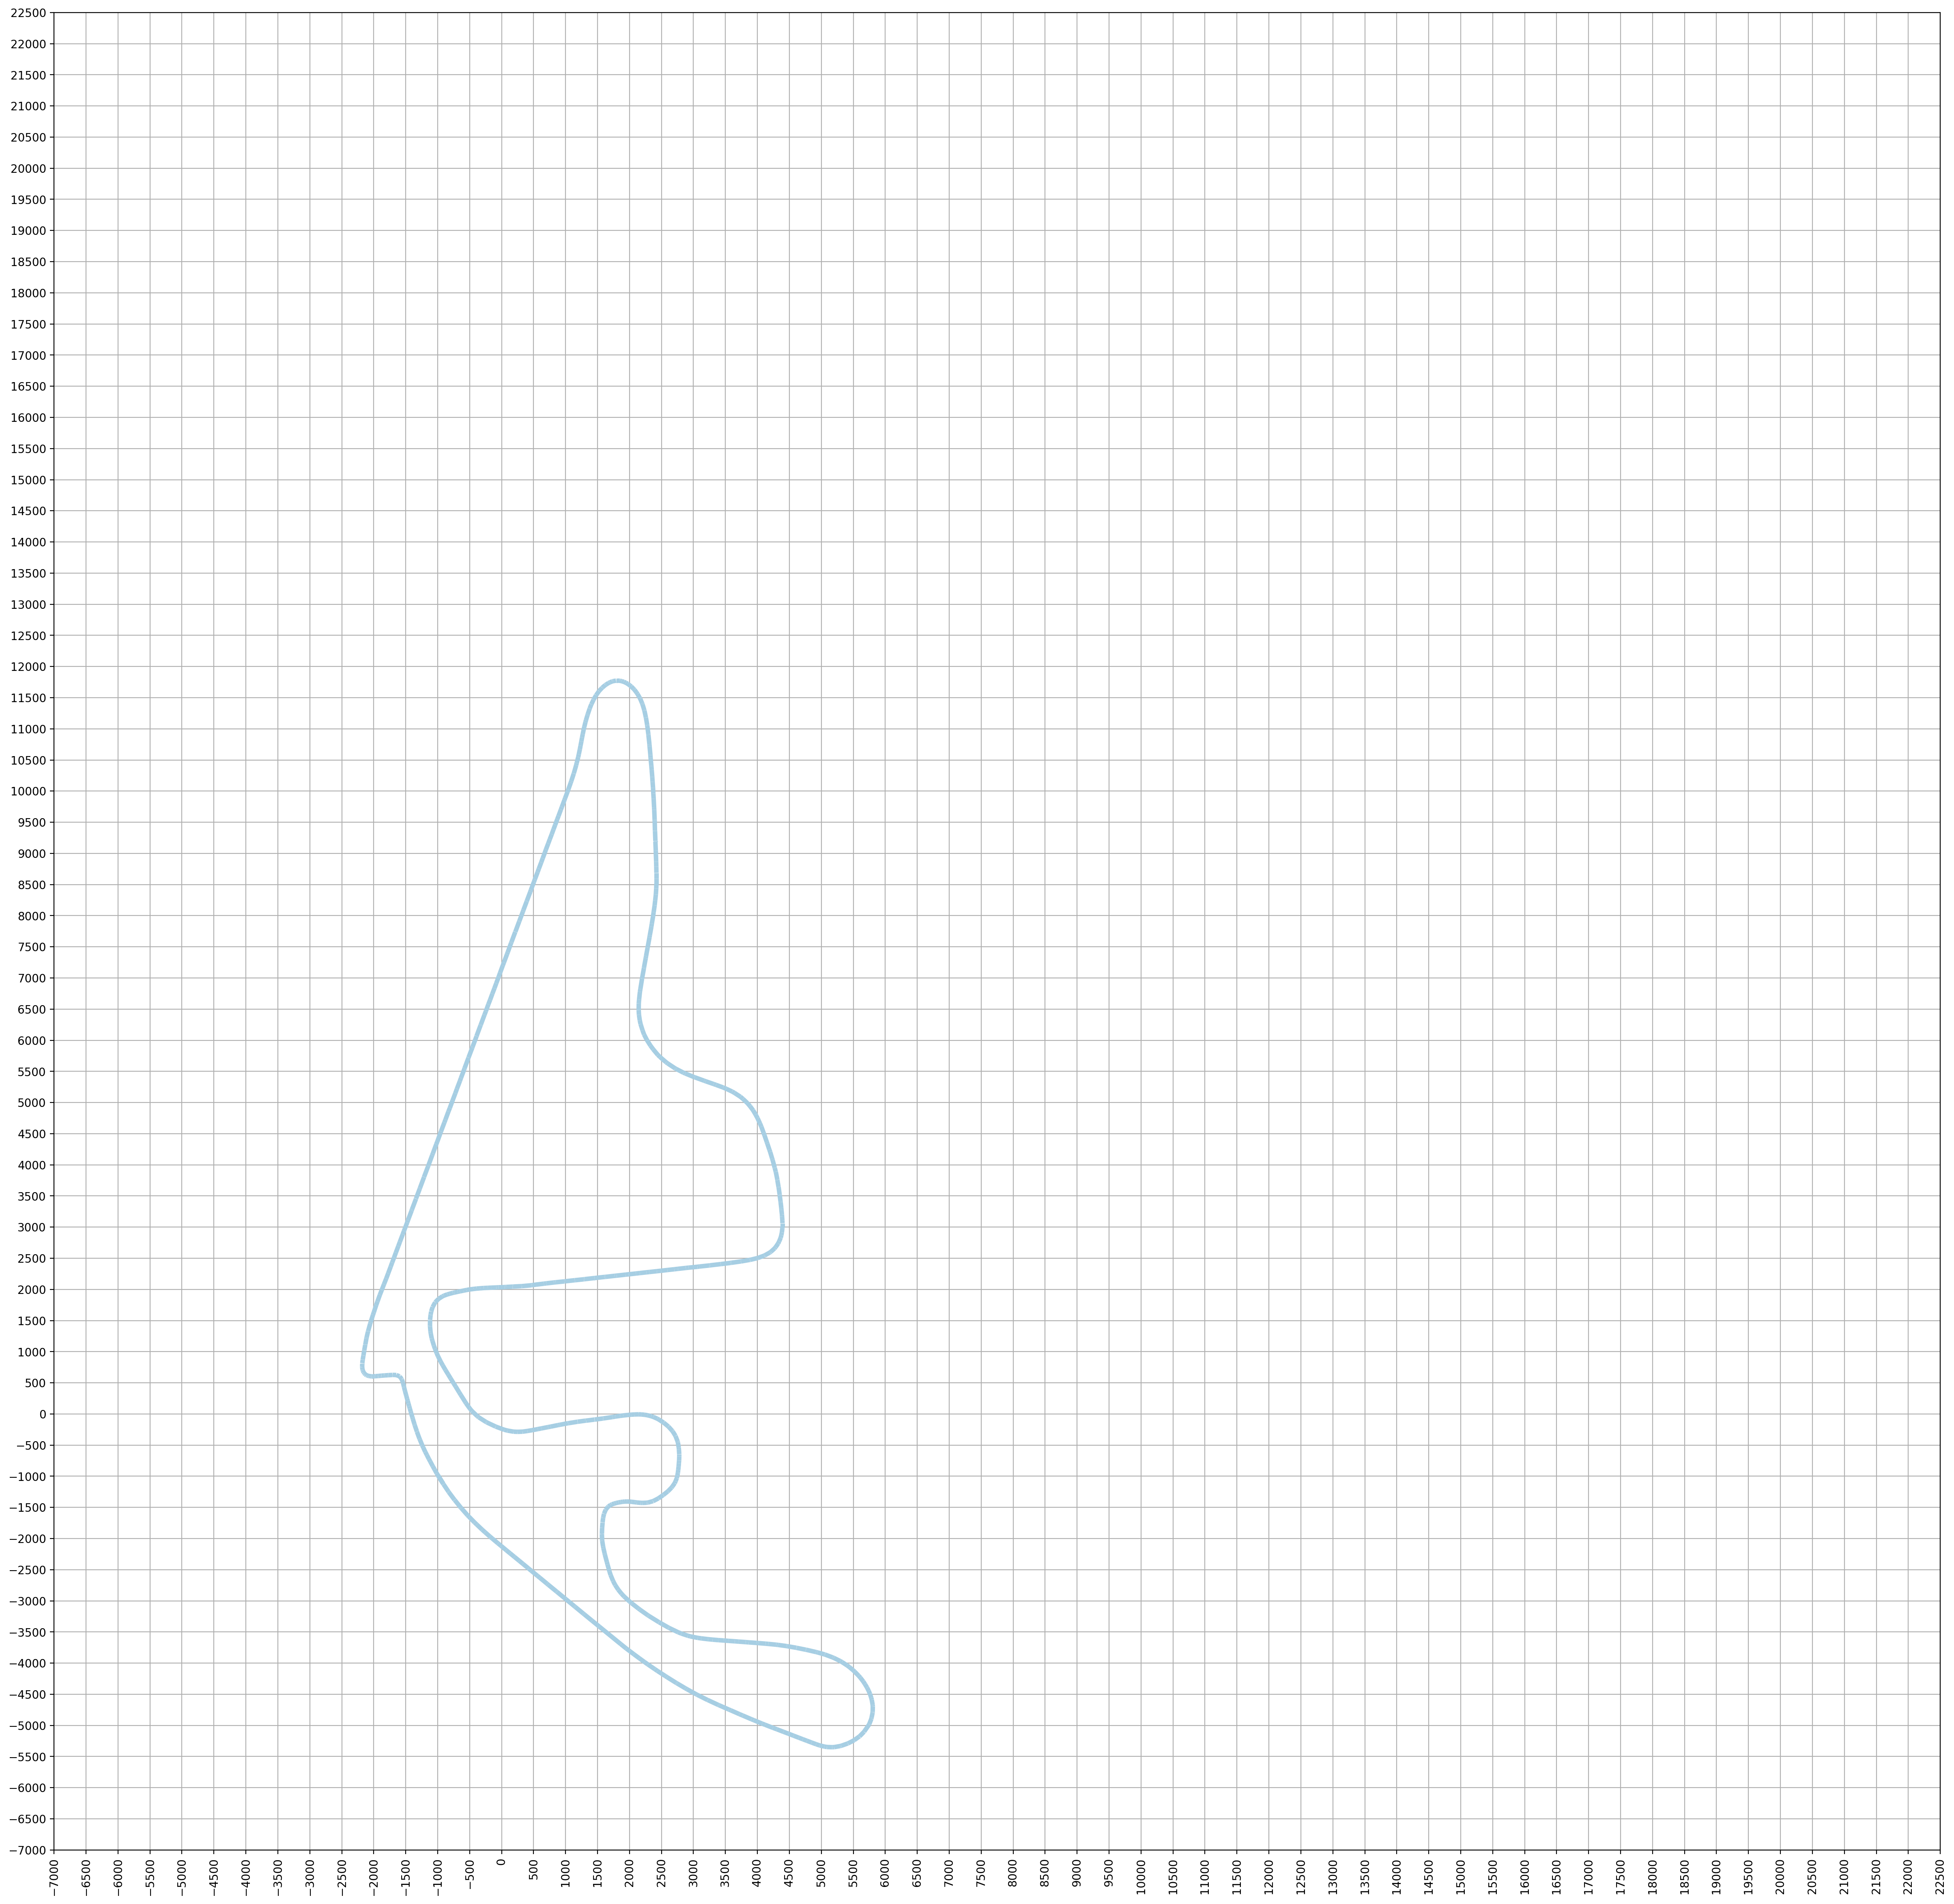

In [163]:
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig,ax = plt.subplots(figsize=(30, 30), dpi=200)

overtake = overtakes_to_display['nOvertakes'].to_numpy().astype(float)

cmap = cm.get_cmap('Paired')
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(overtake)
lc_comp.set_linewidth(4)
ax.add_collection(lc_comp)

# plt.plot(x, y)
# plt.scatter(overtakes_to_display[overtakes_to_display['nOvertakes'] != 0]['X'], overtakes_to_display[overtakes_to_display['nOvertakes'] != 0]['Y'], color='y', s=20)
# plt.scatter(overtakes['X'] * 10 * x_size_of_sector, overtakes['Y'] * 10 * y_size_of_sector, color='r', s=10)
# plt.axis('equal')

major_ticks = np.arange(-7000, 23000, 500)
minor_ticks = np.arange(-7000, 23000, 500)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [113]:
a = np.array([0, 0, 0, 0, 0, 0, 0])
a[2:4] += np.full(2, 1)
a

array([0, 0, 1, 1, 0, 0, 0])